# Práctica 1.2 - CNNs (2024-2025) - Aprendizaje Profundo (Grado en IA)

|Integrantes|Correo electrónico|
|-----------|------------------|
|Hugo Fole Abellás|hugo.fole.abellas@udc.es|
|José Romero Conde|j.rconde@udc.es|

## REDES CONVOLUCIONALES
En esta segunda parte de la práctica desarrollaremos una red convolucional
(CNN) para resolver el mismo problema que en la primera parte, identificar el
elemento o animal que aparece en una fotografía.

Como ya comentamos, volveremos a utilizar el dataset `CIFAR10` de la librería `keras`. Dicho dataset contiene 60.000 imágenes a color de tamaño 32×32 de las que 50.000 se usarán para el entrenamiento de la red y 10.000 para testearla.

Las imágenes pertenecen a las 10 posibles categorı́as (6.000 imágenes por categorı́a).

Inicialmente, importaremos las librería a utilizar.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2024-11-07 02:04:58.900656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730941498.913465   23861 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730941498.917389   23861 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 02:04:58.930119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/folengui/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Un

A continuación, importaremos el dataset que será usado para entrenar la red que crearemos más adelante. 

In [2]:
from keras.datasets import cifar10

(x_train, y_train) , (x_test, y_test) = cifar10.load_data()

## NORMALIZACIÓN DE LOS DATOS
Para poder trabajar de manera correcta con este dataset, deberemos seguir ciertos procesos de normalización de datos, de manera que, o bien optimicemos su tiempo de ejecución o bien nos permita trabajar con el dataset. Estos procesos son :

    1. Realizar One-hot encoding en los targets.
    2. Normalizar los valores de las imágenes a float, ya que vienen en valores de 0 a 255.

Al utilizar redes convolucionales no es necesario aplanar las imágenes en vectores dado que estas realizan la dependencia entre capas utilizando más de un pixel.

### 1. One-hot encoding
Como ya comentamos, haremos one-hot en los targets de nuestro dataset ya que vienen divididos en 10 tipos de salidas categóricas representadas por números. Las diferentes salidas las podemos ver en la siguiente tabla.
|Número|Categoría|
|------|---------|
|0|airplane|
|1|automobile|
|2|bird|
|3|cat|
|4|deer|
|5|dog|
|6|frog|
|7|horse|
|8|ship|
|9|truck|

In [3]:
y_train = keras.utils.to_categorical(y_train, num_classes = 10)
y_test = keras.utils.to_categorical(y_test, num_classes = 10)

### 2.Normalización datos
Como ya dijimos, en este apartado realizaremos la parte de normalización de datos de **uint8** con valores entre [0-255] a **float32**, para que pasen a estar en el rango de valores [0,1] ya que esto nos permite trabajar con redes de neuronas, agiliza el entrenamiento de dichas redes y aumenta la precisión de estas.

Además, utilizaremos el tipo de dato **float32** ya que, los datos ocupan la mitad de espacio y utilizaremos  mucha menos memoria. 

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0



## CREACIÓN REDES NEURONALES CONVOLUCIONALES 

Las redes neuronales convolucionales son un tipo de red que usa datos tridimensionales para la clasificación de imágenes. Se distinguen de otras redes por su alto rendimiento superior con entradas de imagen, voz o señales de audio. Para ello, tienen una composición especial diferente a la de las redes neuronales convencionales. Se componen de:

- `Capa convolucional` : suelen tener más de una y está compuesta por diversos filtros que tienen parámetros entrenables.
- `Capa de agrupación (pooling)` : estas capas se encargan de reducir la dimensionalidad de las capas, esto lo pueden hacer de dos maneras, por medio del valor máximo o del valor medio.
- `Capa "fully connected"` : esta última capa tendrá dimensión K, siendo K el número de clases en las que se puede clasificar. Como su nombre indica es una capa densa, es decir está completamente conectada. Utiliza una función **softmax** para proporcionar el resultado.

Dado que la finalidad de esta práctica es la clasificación, es redundante la utilización de métricas categóricas y funciones de pérdida categóricas también. Se usarán **funciones de pérdida** categóricas como :
- `Categorical Cross Entropy`
- `Categorical Focal Cross Entropy`
- `...`

Y como **métrica** utilizaremos `Categorical Accuracy` ya que es la que nos da una aproximación que queremos dado que tenemos un dataset en el que la salidas son vectores de 10 valores binarios basados en One Hot enconding.

Para representar las gráficas de `loss` y `accuracy` utilizaremos una función que se nos proporcionó en uno de los laboratorios y también utilizamos en la parte 1 de esta práctica.

In [5]:
def plot(train, validation, title):
    plt.clf()
    epochs = range(1, len(train) + 1)
    
    plt.plot(epochs, train, 'b-o', label='Training ' + title)
    plt.plot(epochs, validation, 'r--o', label='Validation '+ title) 

    plt.title('Training and validation ' + title)
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.legend()
    plt.show()
    


Para poder crear redes tendremos que importar de `keras` la función **layers** que nos permite crear diferentes tipos de capas para introducirlas en la redes que crearemos.

In [6]:
from keras import layers

Comenzaremos creando una red sencilla para ver el funcionamiento y composición de esta. En esta red utilizamos la razón de 2^x para seleccionar el número de filtros por cada capa empezando en 32 filtros. Como tamaño de kernels utilizaremos el 3x3 que es uno de los más utilizados en la actualidad en redes convolucionales y como capas pooling utilizaremos filtros de 2x2 que también son de los más utilizados para el pooling en redes convolucionales. Por último, crearemos una única capa completamente conectada con 10 neuronas (una por cada clase de nuestro problema).

In [16]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=4, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

#Compile
model.compile(optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])
#Callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="cnn_cats_dogs_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
#Fitting
history = model.fit(x_train, y_train,validation_split = 0.1 ,epochs=50, batch_size=64,callbacks = callbacks)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - categorical_accuracy: 0.3473 - loss: 1.7760 - val_categorical_accuracy: 0.5484 - val_loss: 1.2693
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - categorical_accuracy: 0.5626 - loss: 1.2340 - val_categorical_accuracy: 0.6098 - val_loss: 1.1244
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - categorical_accuracy: 0.6326 - loss: 1.0540 - val_categorical_accuracy: 0.6454 - val_loss: 0.9962
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.6806 - loss: 0.9281 - val_categorical_accuracy: 0.6716 - val_loss: 0.9517
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.7057 - loss: 0.8493 - val_categorical_accuracy: 0.6846 - val_loss: 0.9030
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.7325 - loss: 0.7738 - val_categorical_accuracy: 0.7096 - val_loss: 0.8514
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy

704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.9739 - loss: 0.0714 - val_categorical_accuracy: 0.7106 - val_loss: 2.3187
Epoch 45/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.9678 - loss: 0.0892 - val_categorical_accuracy: 0.7116 - val_loss: 2.4016
Epoch 46/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.9742 - loss: 0.0737 - val_categorical_accuracy: 0.7052 - val_loss: 2.4322
Epoch 47/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.9793 - loss: 0.0597 - val_categorical_accuracy: 0.7088 - val_loss: 2.6007
Epoch 48/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - categorical_accuracy: 0.9762 - loss: 0.0701 - val_categorical_accuracy: 0.7030 - val_loss: 2.5443
Epoch 49/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.9723 - loss: 0.0774 - val_categorical_accuracy: 0.7066 - val_loss: 2.5163
Epoch 50/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.9

In [17]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.6979 - loss: 2.6316
Test accuracy: 0.692


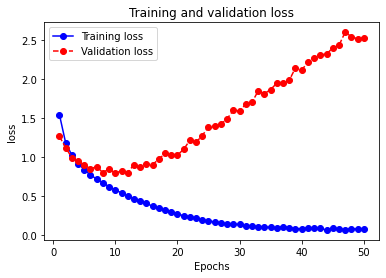

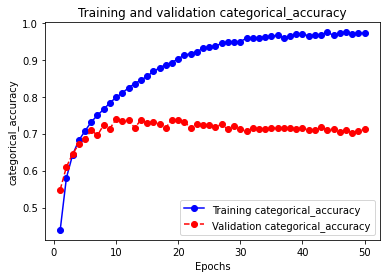

In [18]:
plot(history.history['loss'], history.history['val_loss'], 'loss')
plot(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 'categorical_accuracy')

In [7]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341,216 (1.30 MB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 227,478 (888.59 KB)

Como podemos observar, la mejoría respecto a la práctica anterior es muy notoria. Cuando utilizábamos redes neuronales comunes obteníamos un `accuracy` cercano a 0,5 como máximo, aquí, con la red convolucional más sencilla ya obtenemos un valor de `accuracy` de un 0,71. Esto evidencia la gran superioridad de las redes convolucionales al tratarse de clasificación de imágenes. 

La razón de esto es por la operación de convolución, que permite crear una relación entre un píxel y su entorno, es decir, los píxeles más cercanos a este. Esto es debido a la propiedad de localidad de las imágenes, la cual dice que los píxeles cercanos dentro de una imagen tienden a estar fuertemente correlacionados. Esto, con redes neuronales convencionales sería imposible debido al formato de entrada que tienen, el cual es en vectores unidimensionales, en los que es imposible mapear y hacer relaciones entre píxeles.



A continuación, empezaremos a utilizar otros hiperparámetros como stride o padding.

In [27]:

##Cambiar esto un poquillo / intentar otras distribuciones

inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(filters=10, kernel_size=5,activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=50, kernel_size=3 ,padding = "same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,padding="same")(x)
x = layers.Conv2D(filters=100, kernel_size=2,strides = (2,2), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,padding ="same")(x)
x = layers.Conv2D(filters=300, kernel_size=2, activation="relu")(x)
x = layers.Flatten()(x)


outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

#Compile
model.compile(optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])
#Fitting
history = model.fit(x_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - categorical_accuracy: 0.3178 - loss: 1.8415
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - categorical_accuracy: 0.5040 - loss: 1.3707
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - categorical_accuracy: 0.5655 - loss: 1.2123
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - categorical_accuracy: 0.6098 - loss: 1.0995
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - categorical_accuracy: 0.6456 - loss: 1.0104
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - categorical_accuracy: 0.6616 - loss: 0.9602
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - categorical_accuracy: 0.6889 - loss: 0.8865
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - categorical_accuracy: 0.7063 - loss: 0.8296
Epoch 9/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - categorical_accuracy: 0.7249 - loss: 0.7733
Epoch 10/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - categorical_accuracy: 0.7436 - loss: 0.7249
Epoch 11/20
782/782

In [28]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.6766 - loss: 1.2035
Test accuracy: 0.666


In [12]:
inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(filters=10, kernel_size=3,activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=50, kernel_size=3 ,padding = "same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=3,padding="same")(x)
x = layers.Conv2D(filters=100, kernel_size=4, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,padding ="same")(x)
x = layers.Conv2D(filters=300, kernel_size=2,padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2,padding ="same")(x)
x = layers.Conv2D(filters=600, kernel_size=3,padding="same", activation="relu")(x)

x = layers.Flatten()(x)


outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

#Compile
model.compile(optimizer="RMSProp",
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])
#Fitting
history = model.fit(x_train, y_train,validation_split = 0.1, epochs=20, batch_size=64)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - categorical_accuracy: 0.2300 - loss: 2.0169 - val_categorical_accuracy: 0.3876 - val_loss: 1.6728
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - categorical_accuracy: 0.4914 - loss: 1.3875 - val_categorical_accuracy: 0.4124 - val_loss: 1.8141
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - categorical_accuracy: 0.5881 - loss: 1.1499 - val_categorical_accuracy: 0.5876 - val_loss: 1.1736
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - categorical_accuracy: 0.6469 - loss: 0.9849 - val_categorical_accuracy: 0.5708 - val_loss: 1.3029
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - categorical_accuracy: 0.6933 - loss: 0.8695 - val_categorical_accuracy: 0.5396 - val_loss: 1.4262
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - categorical_accuracy: 0.7246 - loss: 0.7781 - val_categorical_accuracy: 0.5910 - val_loss: 1.2973
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - categorical_accuracy

In [13]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.6639 - loss: 1.8977
Test accuracy: 0.658


En este modelo empezaremos a utilizar capas convolucionales seguidas y mantendremos sus dimensiones utilizando padding para reducirlas solamente en las capas de agrupamiento o pooling. Además, utilizaremos una capa de normalización llamada `BatchNormalization`, más concretamente la usaremos durante la inferencia, para que utilice los valores globales de la media y la desviación del entrenamiento entero.

In [9]:
inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(filters = 32, kernel_size = (3,3),padding = "same",activation = "relu")(inputs)
x = layers.Conv2D(filters = 32, kernel_size = (3,3),padding = "same",activation = "relu")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size= (3,3) ,activation="relu",padding ="same")(x)
x = layers.Conv2D(filters=128, kernel_size= (3,3) ,activation="relu",padding ="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = x = layers.Conv2D(filters = 256, kernel_size = (3,3),padding = "same",activation = "relu")(x)
x = x = layers.Conv2D(filters = 256, kernel_size = (3,3),padding = "same",activation = "relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)

outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
#Compile
model.compile(optimizer="Adam",
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])
#Callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="cnn_cats_dogs_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
#Fitting
history = model.fit(x_train, y_train,validation_split = 0.1 ,epochs=75, batch_size=64,callbacks = callbacks)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,030,378 (3.93 MB)

 Trainable params: 1,029,546 (3.93 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 125s 174ms/step - categorical_accuracy: 0.4316 - loss: 1.8813 - val_categorical_accuracy: 0.5484 - val_loss: 1.3762
Epoch 2/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 126s 178ms/step - categorical_accuracy: 0.6833 - loss: 0.9556 - val_categorical_accuracy: 0.6790 - val_loss: 1.0453
Epoch 3/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 181ms/step - categorical_accuracy: 0.7630 - loss: 0.7063 - val_categorical_accuracy: 0.7400 - val_loss: 0.7904
Epoch 4/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 127s 181ms/step - categorical_accuracy: 0.8256 - loss: 0.5157 - val_categorical_accuracy: 0.7360 - val_loss: 0.8594
Epoch 5/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 127s 181ms/step - categorical_accuracy: 0.8654 - loss: 0.3937 - val_categorical_accuracy: 0.7352 - val_loss: 0.9000
Epoch 6/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 182ms/step - categorical_accuracy: 0.9091 - loss: 0.2638 - val_categorical_accuracy: 0.7682 - val_loss: 0.8040
Epoch 7/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 129s 183ms/step - catego

Epoch 44/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 182ms/step - categorical_accuracy: 0.9955 - loss: 0.0143 - val_categorical_accuracy: 0.8022 - val_loss: 1.5556
Epoch 45/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 182ms/step - categorical_accuracy: 0.9922 - loss: 0.0251 - val_categorical_accuracy: 0.7994 - val_loss: 1.5141
Epoch 46/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 129s 183ms/step - categorical_accuracy: 0.9861 - loss: 0.0468 - val_categorical_accuracy: 0.8018 - val_loss: 1.4373
Epoch 47/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 182ms/step - categorical_accuracy: 0.9967 - loss: 0.0106 - val_categorical_accuracy: 0.7978 - val_loss: 1.6339
Epoch 48/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 182ms/step - categorical_accuracy: 0.9906 - loss: 0.0295 - val_categorical_accuracy: 0.8144 - val_loss: 1.5844
Epoch 49/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 182ms/step - categorical_accuracy: 0.9919 - loss: 0.0253 - val_categorical_accuracy: 0.8040 - val_loss: 1.5532
Epoch 50/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 129s 183ms/step -

In [10]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - categorical_accuracy: 0.7971 - loss: 1.7594
Test accuracy: 0.794


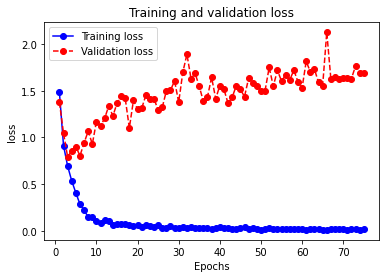

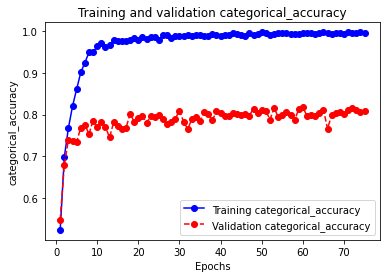

In [11]:
plot(history.history['loss'], history.history['val_loss'], 'loss')
plot(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 'categorical_accuracy')

A continuación, probaremos con un modelo como el anterior pero en el cual utilizaremos regularizaciones en algunas capas en vez de utilizar capas `BatchNormalization`. Además, veremos qué ocurre si añadimos otra capa densa con mayor número de neuronas antes de la capa densa final con 10 neuronas.

Para poder utilizar regularizadores como L1 o L2, tendremos que importar el módulo `regularizers` de la librería `keras`.

In [12]:
from tensorflow.keras import regularizers

In [13]:
inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(filters = 32, kernel_size = (3,3),padding = "same",activation = "relu",kernel_regularizer = regularizers.l2(1e-3))(inputs)
x = layers.Conv2D(filters = 32, kernel_size = (3,3),padding = "same",activation = "relu",kernel_regularizer = regularizers.l2(1e-3))(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size= (3,3) ,activation="relu",padding ="same",kernel_regularizer = regularizers.l2(1e-3))(x)
x = layers.Conv2D(filters=128, kernel_size= (3,3) ,activation="relu",padding ="same",kernel_regularizer = regularizers.l2(1e-3))(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = x = layers.Conv2D(filters = 256, kernel_size = (3,3),padding = "same",activation = "relu",kernel_regularizer = regularizers.l2(1e-3))(x)
x = x = layers.Conv2D(filters = 256, kernel_size = (3,3),padding = "same",activation = "relu",kernel_regularizer = regularizers.l2(1e-3))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(100,activation = "relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
#Compile
model.compile(optimizer="Adam",
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])
#Callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="cnn_cats_dogs_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
#Fitting
history = model.fit(x_train, y_train,validation_split = 0.1 ,epochs=75, batch_size=64,callbacks = callbacks)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,399,478 (5.34 MB)

 Trainable params: 1,398,966 (5.34 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 119s 167ms/step - categorical_accuracy: 0.3837 - loss: 1.9940 - val_categorical_accuracy: 0.5224 - val_loss: 1.4282
Epoch 2/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 118s 168ms/step - categorical_accuracy: 0.6264 - loss: 1.1577 - val_categorical_accuracy: 0.5816 - val_loss: 1.4136
Epoch 3/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 117s 166ms/step - categorical_accuracy: 0.7068 - loss: 0.9313 - val_categorical_accuracy: 0.6428 - val_loss: 1.1879
Epoch 4/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 117s 166ms/step - categorical_accuracy: 0.7527 - loss: 0.8274 - val_categorical_accuracy: 0.7072 - val_loss: 1.0220
Epoch 5/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 118s 167ms/step - categorical_accuracy: 0.7871 - loss: 0.7374 - val_categorical_accuracy: 0.6784 - val_loss: 1.1448
Epoch 6/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 118s 167ms/step - categorical_accuracy: 0.8036 - loss: 0.6970 - val_categorical_accuracy: 0.7522 - val_loss: 0.8849
Epoch 7/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 117s 166ms/step - catego

Epoch 44/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - categorical_accuracy: 0.9556 - loss: 0.3194 - val_categorical_accuracy: 0.7658 - val_loss: 1.4690
Epoch 45/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 115s 164ms/step - categorical_accuracy: 0.9716 - loss: 0.2729 - val_categorical_accuracy: 0.7482 - val_loss: 1.7230
Epoch 46/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - categorical_accuracy: 0.9602 - loss: 0.2975 - val_categorical_accuracy: 0.7458 - val_loss: 1.6578
Epoch 47/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 115s 164ms/step - categorical_accuracy: 0.9563 - loss: 0.3183 - val_categorical_accuracy: 0.7190 - val_loss: 1.8193
Epoch 48/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 164ms/step - categorical_accuracy: 0.9600 - loss: 0.3040 - val_categorical_accuracy: 0.7514 - val_loss: 1.6057
Epoch 49/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - categorical_accuracy: 0.9632 - loss: 0.2991 - val_categorical_accuracy: 0.7596 - val_loss: 1.6305
Epoch 50/75
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step -

In [14]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {acc:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - categorical_accuracy: 0.7529 - loss: 1.7853
Test accuracy: 0.747


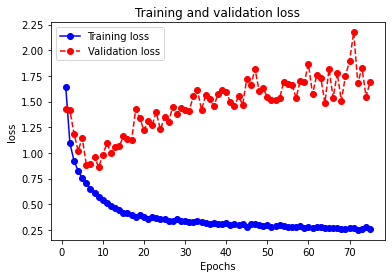

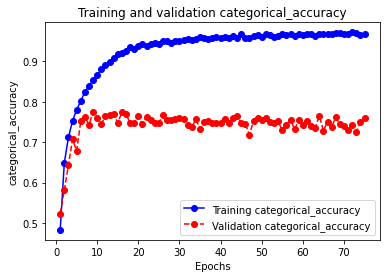

In [15]:
plot(history.history['loss'], history.history['val_loss'], 'loss')
plot(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 'categorical_accuracy')